I am going to use all the labels provided by the sources (even if they are not in the "verified" labels), 
because the images have been selected to the "confirmed".

The annotations are given in the following order: row, column, label -> height, width, label.

Image shapes are in the same order: height, width, color

In [2]:
# Import necessary libraries

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch

from PIL import Image
from skimage import io, transform
from sklearn.preprocessing import MinMaxScaler  

/home/jantina/.local/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [5]:
# Prepare labels set with all labels

labels = pd.DataFrame(columns = ['Label ID', 'Short Code'])

# Assign directory
directory = '/data/jantina/CoralNet'
 
# Iterate over files in that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    os.chdir(f)
    
    # Get labels
    df = pd.read_csv('labelset.csv')
    labels=labels.append(df, ignore_index = True)
    
# Remove duplicates
labels.drop_duplicates(inplace = True, ignore_index = True)

# Prepare labels as dictionary
# Using numbers from 1 -> N-1
labels = labels["Short Code"]
labels.index = labels.index + 1
labels = labels.to_dict()

# Remove key 255 and replace with 0
labels[0] = labels[255]
del labels[255]

# Using Label ID
#labels = pd.read_csv('labelset.csv', header=0, index_col=0, squeeze=True).to_dict()
#labels = {v: k for k, v in labels.items()}

# Save label file
os.chdir("/home/jantina/CoralNet/Preprocessing")
with open('labels.csv', 'w') as f:
    for key in labels.keys():
        f.write("%s,%s\n"%(key,labels[key]))

/home/jantina/CoralNet/Preprocessing


In [57]:
# Create masks for single source

os.chdir("/data/jantina/CoralNet/WAPA_RFM")

# Prepare annotations
annotations = pd.read_csv('annotations.csv')
img_names = annotations.iloc[:, 0]
landmarks = annotations.iloc[:, 1:4]

# Prepare labels as dictionary
# Using numbers from 1 -> N-1
labels = pd.read_csv('labelset.csv')["Short Code"]
labels.index = labels.index + 1
labels = labels.to_dict()

for img_name in img_names.unique():
    os.chdir("/data/jantina/CoralNet/WAPA_RFM")
    landmark = landmarks.iloc[img_names[img_names==img_name].index.values]
    landmark = np.asarray(landmark)
    image = io.imread(os.path.join('images', img_name))
    
    # Get image information
    height = image.shape[0]
    width = image.shape[1]
    colors = image.shape[2]
    
    # Create array with coordinates and label code
    classes = np.copy(landmark) 
    for new, old in labels.items():
        classes[landmark == old] = new
        
    # Create mask 
    mask = np.full((height, width), 255)
    for x in classes:
        try:
            mask[x[0], x[1]] = x[2]
        except:
            print(img_name)
            print("These labels are out of bounds", x[0], x[1], x[2])
            continue
    
    img_name = img_name.split(".JPG")[0]+".png"
    
    #scaler = MinMaxScaler()
    #mask = scaler.fit_transform(mask)
    #print(img_name, np.unique(mask))
    
    # Save mask
    #os.chdir("/home/jantina/CoralNet/ML-Superpixels/Lizard_Heron/sparse_GT")
    os.chdir("/data/jantina/CoralNet/WAPA_RFM/masks")
    cv2.imwrite(img_name, mask)
    image = cv2.imread(os.path.join(img_name))
    #print(img_name, np.unique(image))

(4000, 3000, 3)
(3000, 4000, 3)


True

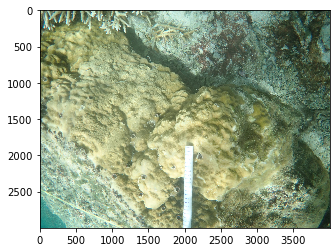

In [55]:
# Rotating images

os.chdir("/data/jantina/CoralNet/WAPA_RFM")

# Prepare annotations
annotations = pd.read_csv('annotations.csv')
img_names = annotations.iloc[:, 0]
landmarks = annotations.iloc[:, 1:4]

# Prepare labels as dictionary
# Using numbers from 1 -> N-1
labels = pd.read_csv('labelset.csv')["Short Code"]
labels.index = labels.index + 1
labels = labels.to_dict()

# Take a single image
img_name = "2020-08-07-ADELUP-B-T3 2.5-B (P8072737).JPG"
landmark = landmarks.iloc[img_names[img_names==img_name].index.values]
landmark = np.asarray(landmark)

image = io.imread(os.path.join('images', img_name))
print(image.shape)
plt.imshow(image)

img = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
print(img.shape)
plt.imshow(img)
os.chdir("/data/jantina/CoralNet/WAPA_RFM/images")
cv2.imwrite(img_name, img)

(3000, 4000, 3)
2020-08-07-ADELUP-B-T3 2.5-B (P8072737).png [ 13  37 101 118 120 126 255]
2020-08-07-ADELUP-B-T3 2.5-B (P8072737).png [ 13  37 101 118 120 126 255]


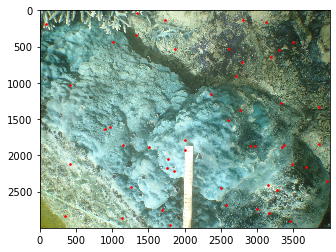

In [56]:
# Create masks for single image

os.chdir("/data/jantina/CoralNet/WAPA_RFM")

# Prepare annotations
annotations = pd.read_csv('annotations.csv')
img_names = annotations.iloc[:, 0]
landmarks = annotations.iloc[:, 1:4]

# Prepare labels as dictionary
# Using numbers from 1 -> N-1
labels = pd.read_csv('labelset.csv')["Short Code"]
labels.index = labels.index + 1
labels = labels.to_dict()

# Take a single image
img_name = "2020-08-07-ADELUP-B-T3 2.5-B (P8072737).JPG"
landmark = landmarks.iloc[img_names[img_names==img_name].index.values]
landmark = np.asarray(landmark)

image = io.imread(os.path.join('images', img_name))
print(image.shape)

# Get image information
height = image.shape[0]
width = image.shape[1]
colors = image.shape[2]

# Create array with coordinates and label code
classes = np.copy(landmark) 
for new, old in labels.items():
    classes[landmark == old] = new
    
# Create mask 
mask = np.full((height, width), 255)
for x in classes:
    try:
        mask[x[0], x[1]] = x[2]
    except:
        print("these labels are out of bounds", x[0], x[1], x[2])
        continue

img_name = img_name.split(".JPG")[0]+".png"
    
#scaler = MinMaxScaler()
#mask = scaler.fit_transform(mask)
print(img_name, np.unique(mask))

# Save mask
os.chdir("/data/jantina/CoralNet/WAPA_RFM/masks")
cv2.imwrite(img_name, mask)
image = cv2.imread(os.path.join(img_name))
print(img_name, np.unique(image))

# Plot the single image
os.chdir("/data/jantina/CoralNet/WAPA_RFM")
img_name = "2020-08-07-ADELUP-B-T3 2.5-B (P8072737).JPG"
landmarks = annotations.iloc[:, 1:3]
landmarks = landmarks.iloc[img_names[img_names==img_name].index.values]
landmarks = np.asarray(landmarks).astype('float').reshape(-1, 2)

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 1], landmarks[:, 0], s=10, marker='.', c='r')

plt.figure()
show_landmarks(io.imread(os.path.join('images', img_name)),landmarks)
plt.show()